In [29]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split 
from sklearn.neural_network import MLPRegressor
from sklearn.multioutput import MultiOutputRegressor 
from sklearn.metrics import classification_report, confusion_matrix

In [30]:
def InsertBorder(image):
    new_image = np.zeros((image.shape[0]+2, image.shape[1]+2, image.shape[2]))
    
    #Copying the image 
    for i in range(0,image.shape[0]):
        for j in range(0,image.shape[1]):
            new_image[i+1,j+1,:] = image[i,j,:]
    
    #Inserting the border
    new_image[0,:,:] = new_image[1,:,:]
    new_image[new_image.shape[0]-1,:,:] = new_image[new_image.shape[0]-2,:,:]
    
    new_image[:,0,:] = new_image[:,1,:]
    new_image[:,new_image.shape[1]-1,:] = new_image[:,new_image.shape[1]-2,:]
    return np.uint8(new_image)

In [31]:
def BGR2YCrCb(image):
    Y = image[:, :, 0] * 0.114 + image[:, :, 1] * 0.587 + image[:, :, 2] * 0.299
    Cr = 0.713 * image[:, :, 2] - 0.713 * Y[:, :]
    Cb = 0.564 * image[:, :, 0] - 0.564 * Y[:, :]

    return cv2.merge([Y, Cr, Cb])

def YCrCb2BGR(image):
    R = ((image[:, :, 0]) + (1.402 * image[:, :, 1]))
    G = ((image[:, :, 0]) - (0.344 * image[:, :, 2]) - (0.714 * image[:, :, 1]))
    B = ((image[:, :, 0]) + (1.772 * image[:, :, 2]))

    return cv2.merge([B, G, R])

In [32]:
def ExtractFeatures(image):
    
    new_image = InsertBorder(image)
    imageYCbCr = BGR2YCrCb(new_image)
    imageY = imageYCbCr[:,:,0]
    
    k = 0;
    features = np.zeros(((image.shape[0])*(image.shape[1]),9))
    
    for i in range(1,imageY.shape[0]-1):
        for j in range(1,imageY.shape[1]-1):
            features[k,0] = imageY[i-1,j-1]
            features[k,1] = imageY[i,j-1]
            features[k,2] = imageY[i+1,j-1]
            features[k,3] = imageY[i-1,j]
            features[k,4] = imageY[i,j]
            features[k,5] = imageY[i+1,j]
            features[k,6] = imageY[i-1,j+1]
            features[k,7] = imageY[i,j+1]
            features[k,8] = imageY[i+1,j+1]
            k += 1
    
    return features

In [33]:
def ExtractTargets(image):
    imageYCbCr = BGR2YCrCb(image)
    
    imageCr = imageYCbCr[:,:,1]
    imageCb = imageYCbCr[:,:,2]
    
    ImageCbVec = np.reshape(imageCb, (imageCb.shape[0]*imageCb.shape[1],1))
    ImageCrVec = np.reshape(imageCr, (imageCr.shape[0]*imageCr.shape[1],1))

    target = np.concatenate((ImageCbVec, ImageCrVec), 1)
    
    return target

In [34]:
def RecoverImage(imagevec,imageY,m,n):
    
    imageCb = np.reshape(imagevec[:,0], (m,n))
    imageCr = np.reshape(imagevec[:,1], (m,n))
    imageYCbCr = cv2.merge([imageY,imageCr, imageCb])
    
    image = YCrCb2BGR(imageYCbCr)
    
    
    return image

In [35]:
image = cv2.imread('dragao.png')
Data = ExtractFeatures(image)
Target = ExtractTargets(image)

In [36]:
BestAccuracy = 0
BestNeurons = 0
for neurons in range(8,11):
    for i in range(0,5):
        #XTrain, XTest, YTrain, YTest = train_test_split(Data, Target, test_size = 0.20)
        NeuralNetwork = MLPRegressor(hidden_layer_sizes=(neurons), max_iter=2000, verbose=False) 
        NeuralNetwork.fit(Data, Target)  

        #predictions = NeuralNetwork.predict(XTest)  
        #print(classification_report(y_test,predictions))
        accuracy = NeuralNetwork.score(Data,Target)

        #YConfusion = np.argmax(YTest, axis = 1)
        #XConfusion = np.argmax(predictions, axis = 1)
        #print(confusion_matrix(YConfusion, XConfusion))

        if accuracy > BestAccuracy:
            BestAccuracy = accuracy
            BestNeurons = neurons
            BestNN = NeuralNetwork

In [37]:
print("Melhor Acuracia:")
print(BestAccuracy)

print("Quantidade de Neuronios:")
print(BestNeurons)

Melhor Acuracia:
0.48436670061490567
Quantidade de Neuronios:
8


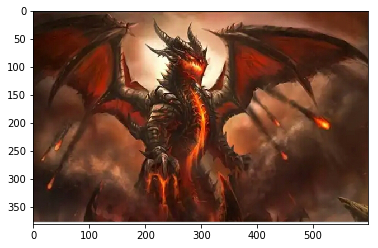

In [38]:
predictions = BestNN.predict(Data)  

imageYCbCr = BGR2YCrCb(image)
imageY = imageYCbCr[:,:,0]

m = image.shape[0]
n = image.shape[1]
recover = RecoverImage(predictions,imageY,m,n)

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

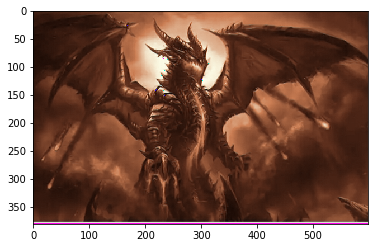

In [39]:
plt.imshow(cv2.cvtColor(np.uint8(recover), cv2.COLOR_BGR2RGB))